In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import norm
from scipy.special import gamma as gamma_func
from scipy.special import beta as beta_func
from scipy.special import gammaln, xlogy
from scipy.integrate import quad
import tikzplotlib as tpl
np.random.seed(42)

In [3]:
# Make inline plots vector graphics
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "svg")

#matplotlib.rc("font", **{"family": "serif", "serif": ["Times Roman"]})
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsfonts} \usepackage{amsmath}"

# Dirichlet Bridge

In [4]:
## functions

def softmax_transform(x):
    
    exp_ = np.exp(x)
    return(exp_/exp_.sum())

def dirichlet_pdf(x, alpha):
    
    alpha = np.array(alpha)
    x = np.array(x)
    coef = np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))  

    return(np.exp(- coef+ np.sum((xlogy(alpha-1, x.T)).T, 0)))

def dirichlet_t_softmax_pdf(x, alpha):
    
    alpha = np.array(alpha)
    x_sm = softmax_transform(np.array(x))
    coef = np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))
    
    return(np.exp(- coef+ np.sum((xlogy(alpha, x_sm.T)).T, 0)))

def dirichlet_mu(alpha):
    alpha = np.array(alpha)
    K = len(alpha)
    return((alpha-1)/(alpha.sum()- K))
    
def dirichlet_Sigma(alpha):
    alpha = np.array(alpha)
    K = len(alpha)
    diag_ = (alpha - 1)/(alpha.sum() - K)**2
    S = np.diag(diag_)
    return(S)
    
# softmax basis

def dirichlet_t_softmax_mu(alpha):
    
    alpha = np.array(alpha)
    log_ = np.log(alpha)
    K = len(alpha)
    return(log_ - 1/K * log_.sum())
    
def dirichlet_t_softmax_Sigma(alpha):
    
    alpha = np.array(alpha)
    K = len(alpha)
    inv_alpha_sum = (1/alpha).sum()
    
    Sigma = np.zeros((K, K))
    for k in range(K):
        for l in range(K):
            v = -1/K * (1/alpha[k] + 1/alpha[l] - 1/K * inv_alpha_sum)
            if k == l:
                v += 1/alpha[k]
            Sigma[k, l] =  v
            
    return(Sigma)

#"""
def inverse_softmax_transform_all(y,c=1):
    
    x = log(y) * c
    return(x)

def inverse_softmax_transform_all(y):
    # Note: the softmax function is not bijective, hence has not one inverse.
    # inverses have the form of (log(x_0), log(x_1), ...) * C
    # since we assume sum(x) = 0 we can only choose x = log(y) - 1/K * sum(log(y))
    # We assume to receive an array of values drawn from the Dirichlet which we can transform
    
    x = np.log(y) - np.mean(np.log(y), 1).reshape(-1, 1)
    assert(np.allclose(x.sum(1), np.zeros(len(y))))
    
    return(x)

def inverse_softmax_transform_single(y):
    
    x = np.log(y) - np.mean(np.log(y))
    assert(np.allclose(x.sum(), 0))
    
    return(x)
#"""

#"""
from scipy.stats import multivariate_normal as mv_norm
def fake_inverse_softmax_Gaussian_pdf(y, mu, Sigma):
    
    x = inverse_softmax_transform_single(y)
    
    K = np.shape(x)[-1]
    ones = np.ones(K)
    mu_bar = mu - (Sigma @ np.outer(ones, ones) @ mu)/(ones @ Sigma @ ones)
    Sigma_bar = Sigma - (Sigma @ np.outer(ones, ones) @ Sigma)/(ones @ Sigma @ ones)
    Sigma_bar += 1e-8*np.eye(K)
    
    det_ = 1/K * np.prod(1/(y[:-1]))
    m = np.zeros((K-1, K-1))
    for i in range(K-1):
        for j in range(K-1):
            m[i,j] = - 1/K * 1/y[i]
            if i == j: m[i,j] += 1/y[i]
    #print(m)
    #print(np.diag(y[:-1]) - 1/K * np.outer(np.ones(K-1), y[:-1]))
    det2_ = np.linalg.det(m)
    #print("det: ", det_)
    #print("det2: ", det2_)
    
    return(mv_norm.pdf(x, mu_bar, Sigma_bar) * det2_)

def softmax_Gaussian_pdf(x, mu, Sigma):
    
    K = len(mu)
    sm_x = softmax_transform(x)
    Jac = np.zeros((K,K))
    for i in range(K):
        for j in range(K):
            Jac[i,j] = -sm_x[i]*sm_x[j]
            if i == j:
                Jac[i,j] += sm_x[i]
                
    det_ = np.linalg.det(Jac)
    print(det_)
    y = mv_norm.pdf(sm_x, mu, Sigma) #* det_
    return(y)

#"""

def multivariate_normal_pdf_test_exp_log(X, mu, Sigma):
    k = np.shape(X)[0]
    a = -k/2 * np.log(2*np.pi)
    b = -1/2 * np.log(np.linalg.det(Sigma))
    x_mu = (X-mu).reshape(-1)
    c = -1/2 * x_mu.T @ np.linalg.inv(Sigma) @ x_mu
    return(np.exp(a+b+c))

In [5]:
def beta_mu(a, b):
    return((a-1)/(a+b-2))

def beta_var(a, b):
    return(((a-1)*(b-1))/(a+b-2)**3)

"""transform: logit"""

def logit_transform(theta):
    return(np.log(theta/(1-theta)))

def logit_derivative(x):
    return(1/x + 1/(1-x))

def logistic_transform(a):
    return(1 / (1 + np.exp(-a)))

def logistic_derivative(x):
    return(logistic_transform(x) * (1- logistic_transform(x)))

def beta_t_logit_mu(a,b):
    return(np.log(a/b))

def beta_t_logit_var(a,b):
    return((a+b)/(a*b))

def beta_t_logit_pdf(x, a, b):
    x_t = logistic_transform(x)
    nom = (x_t) ** (a) * (1- x_t) ** (b)
    denom = beta_func(a, b)
    return((nom/denom))

def logit_normal_back(x, mu, sigma):
    x_ = logit_transform(x)
    return(norm.pdf(x_, mu, sigma) * logit_derivative(x))

In [6]:
## plotting

def plot_dirichlet_t_softmax(params, save=False, filename='dirichlet_softmax_bridge.pdf', show_back=True):
    
    a1 = params[0] 
    a2 = params[1] 
    a3 = params[2] 
    
    x_ = np.linspace(0,1, 1000 +1)
    x = np.array([[x_i, 1-x_i] for x_i in x_])
    
    print("using only 2D Dirichlet for plotting (i.e. the special case of the Beta dist.)")
    
    mode1 = dirichlet_mu(a1)[0]
    mode2 = dirichlet_mu(a2)[0]
    mode3 = dirichlet_mu(a3)[0]
    
    beta_sigma1 = np.sqrt(beta_var(a1[0], a1[1]))
    beta_sigma2 = np.sqrt(beta_var(a2[0], a2[1]))
    beta_sigma3 = np.sqrt(beta_var(a3[0], a3[1]))
    
    print(beta_sigma2, beta_sigma3)

    y1 = np.array([dirichlet_pdf(_, a1) for _ in x])
    y2 = np.array([dirichlet_pdf(_, a2) for _ in x])
    y3 = np.array([dirichlet_pdf(_, a3) for _ in x])
    
    print(np.shape(y1))
    
    LP_approx1 = norm.pdf(x_, mode1, beta_sigma1)
    LP_approx2 = norm.pdf(x_, mode2, beta_sigma2)
    LP_approx3 = norm.pdf(x_, mode3, beta_sigma3)
    
    print(np.shape(LP_approx1))

    #plot 2: transform to other base
    x_t = np.linspace(-4,4, 1000 + 1)
    
    y1_t_logit = beta_t_logit_pdf(x_t, a1[0], a1[1])
    y2_t_logit = beta_t_logit_pdf(x_t, a2[0], a2[1])
    y3_t_logit = beta_t_logit_pdf(x_t, a3[0], a3[1])

    mode1_t_logit = beta_t_logit_mu(a1[0], a1[1])
    mode2_t_logit = beta_t_logit_mu(a2[0], a2[1])
    mode3_t_logit = beta_t_logit_mu(a3[0], a3[1])

    sigma1_t_logit = np.sqrt(beta_t_logit_var(a1[0], a1[1]))
    sigma2_t_logit = np.sqrt(beta_t_logit_var(a2[0], a2[1]))
    sigma3_t_logit = np.sqrt(beta_t_logit_var(a3[0], a3[1]))

    LP_approx1_t_logit = norm.pdf(x_t, mode1_t_logit, sigma1_t_logit)
    LP_approx2_t_logit = norm.pdf(x_t, mode2_t_logit, sigma2_t_logit)
    LP_approx3_t_logit = norm.pdf(x_t, mode3_t_logit, sigma3_t_logit)
    
    
    #plot 3: transform back and reconstruct
    if show_back:
        y1_back = logit_normal_back(x_, mode1_t_logit, sigma1_t_logit)
        y2_back = logit_normal_back(x_, mode2_t_logit, sigma2_t_logit)
        y3_back = logit_normal_back(x_, mode3_t_logit, sigma3_t_logit)

    """Plots"""
    plt.rc('text', usetex=True)
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=15)
    plt.rc('axes', labelsize=15)
    
    legend_size=14
    xlabel_size=15
    ylabel_size=15
    title_size=15
    lw_size=2
    
    if show_back:
        fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(10, 3))
    else:
        fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(10, 3))
    #plot beta distribution and LPA in the standard basis
    axs[0].plot(x_, y1, 'r-', lw=lw_size)
    axs[0].plot(x_, y2, 'b-', lw=lw_size)
    axs[0].plot(x_, y3, 'k-', lw=lw_size, label='$\mathcal{D}$')
    axs[0].plot(x_, LP_approx1, 'r--', lw=lw_size)
    axs[0].plot(x_, LP_approx2, 'b--', lw=lw_size)
    axs[0].plot(x_, LP_approx3, 'k--', lw=lw_size, label='$\mathcal{N}$')
    axs[0].set_yticklabels([])
    axs[0].set_yticks([])
    axs[0].set_xlabel('$\pi$', fontsize=xlabel_size)
    axs[0].set_ylabel('$p(\pi)d\pi$', fontsize=ylabel_size)
    axs[0].set_title('Laplace in standard basis', fontsize=title_size)
    axs[0].legend(prop={'size': legend_size});

    #plot beta distribution in the transformed basis
    axs[1].plot(x_t, y1_t_logit, 'r-', lw=lw_size)
    axs[1].plot(x_t, y2_t_logit, 'b-', lw=lw_size)
    axs[1].plot(x_t, y3_t_logit, 'k-', lw=lw_size, label='$\mathcal{D}$')
    axs[1].plot(x_t, LP_approx1_t_logit, 'r--', lw=lw_size)
    axs[1].plot(x_t, LP_approx2_t_logit, 'b--', lw=lw_size)
    axs[1].plot(x_t, LP_approx3_t_logit, 'k--', lw=lw_size, label='$\mathcal{N}$')
    axs[1].set_xlabel('x', fontsize=xlabel_size)
    axs[1].set_ylabel('$p(x)dx$', fontsize=ylabel_size)
    axs[1].set_yticklabels([])
    axs[1].set_yticks([])
    axs[1].set_title('Laplace in inverse-softmax basis', fontsize=title_size)
    axs[1].legend(prop={'size': legend_size});

    #plot backwards transformation of the LPA from the transformed to the standard basis
    if show_back:
        axs[2].plot(x_, y1, 'r-', lw=lw_size)
        axs[2].plot(x_, y2, 'b-', lw=lw_size)
        axs[2].plot(x_, y3, 'k-', lw=lw_size, label='$\mathcal{D}$')
        axs[2].plot(x_, y1_back, 'r--', lw=lw_size)
        axs[2].plot(x_, y2_back, 'b--', lw=lw_size)
        axs[2].plot(x_, y3_back, 'k--', lw=lw_size, label='$\mathcal{N}$')
        axs[2].set_yticklabels([])
        axs[2].set_yticks([])
        axs[2].set_xlabel('$\pi$', fontsize=xlabel_size)
        axs[2].set_ylabel('$p(\pi)d\pi$', fontsize=ylabel_size)
        axs[2].set_title('Transformation back to standard basis', fontsize=title_size)
        axs[2].legend(prop={'size': legend_size});

    plt.tight_layout()
    #plt.show()
    #plt.savefig('BetaVizTransformation.pdf')
    #tpl.save('BetaVizTransformation.tex', figure=fig, tex_relative_path_to_data='.figures', figurewidth='\\figwidth', figureheight='\\figheight',
    #         extra_axis_parameters={'xtick align=inside', 'ytick align=inside', 'xtick pos=left', 'ytick pos=left', 'legend pos=north east'})

    if save:
        plt.savefig(filename)

using only 2D Dirichlet for plotting (i.e. the special case of the Beta dist.)
0.2721655269759087 0.1870439059165649
(1001,)
(1001,)


/home/marius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt
/home/marius/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/home/marius/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
/home/marius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/marius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/marius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys

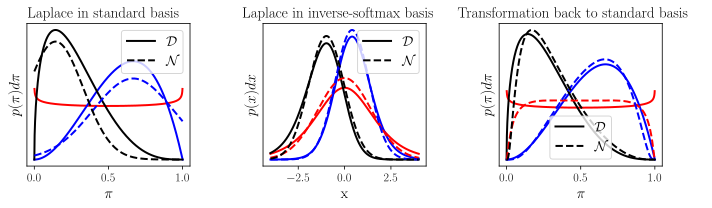

In [7]:
plot_dirichlet_t_softmax(params=[[0.95, 0.95], [3,2], [1.5, 4]], save=True, filename='dirichlet_softmax_bridge.pdf', show_back=True)

# Verify the Bridge

In [8]:
def alpha_from_normal(mu, Sigma):
    
    Sigma_diag = np.diagonal(Sigma)
    sum_mu_exp = np.sum(np.exp(-mu))
    K = len(mu)
    return(1/Sigma_diag * (1 - 2/K + np.exp(mu)/K**2 * sum_mu_exp))

test_a1 = np.array([1,2,3,4])
test_m1, test_S1 = dirichlet_t_softmax_mu(test_a1), dirichlet_t_softmax_Sigma(test_a1)
test_a2 = alpha_from_normal(test_m1, test_S1)
print(test_a2)

test_a3 = np.random.random(4)
test_m3, test_S3 = dirichlet_t_softmax_mu(test_a3), dirichlet_t_softmax_Sigma(test_a3)
test_a4 = alpha_from_normal(test_m3, test_S3)

assert(np.allclose(test_a3, test_a4))

[1. 2. 3. 4.]


# Statistical distance measures

In [9]:
from torch_two_sample import MMDStatistic
from scipy.stats import norm, beta, dirichlet
from scipy.stats import multivariate_normal as mv_norm
import torch

## MMD from 100 combinations of parameters

In [10]:
def MMD_combinations(params, plot=False, n_samples=1000, verbose=True):
    
    As = params
    
    MMD_sum = 0
    MMD_t_softmax_sum = 0 

    for a in As:
            
        if verbose:
            print("a: ", a)
                
        if np.sum(a < 1) != 0:
            print("a_i < 1 doesn't yield a Laplace Approximation in standard basis")

        if np.sum(a) == len(a):
            print("sum of alphas is K, division by zero -> break")
            MMD_ = torch.Tensor([np.nan])
            MMD_softmax_ = torch.Tensor([np.nan])
            
        else:
            #get samples from all dists
            #standard
            D_samples = dirichlet.rvs(a, size=n_samples)
            if np.sum(a < 1) == 0:                
                mode1 = dirichlet_mu(a)
                Sigma1 = dirichlet_Sigma(a)
                N_samples = mv_norm.rvs(mode1, Sigma1, size=n_samples)

            #softmax
            mode1_softmax = dirichlet_t_softmax_mu(a)
            Sigma1_softmax = dirichlet_t_softmax_Sigma(a)
            D_samples_softmax = inverse_softmax_transform_all(D_samples)
            #D_samples_softmax = inverse_softmax_transform(D_samples)
            #we align the means of the normal and the inverse softmax transform since we don't know the
            #exact value of the constant for the inversion c
            N_samples_softmax = mv_norm.rvs(mode1_softmax, Sigma1_softmax, size=n_samples)
            N_samples_softmax += np.mean(D_samples_softmax, axis=1).reshape(-1, 1)
            #print(np.shape(np.mean(D_samples_softmax, axis=1)))


            #calculate MMD for all bases
            MMD = MMDStatistic(n_samples, n_samples)

            #standard
            D_samples_ = torch.Tensor(D_samples.reshape((n_samples, -1)))
            if np.sum(a < 1) == 0:
                N_samples_ = torch.Tensor(N_samples.reshape((n_samples, -1)))
                MMD_ = MMD(D_samples_, N_samples_,  alphas=[0.5], ret_matrix=False)
                MMD_ = torch.max(torch.zeros(1), MMD_)
            else:
                MMD_ = torch.Tensor([np.nan])

            #softmax
            D_samples_softmax_ = torch.Tensor(D_samples_softmax.reshape((n_samples, -1)))
            N_samples_softmax_ = torch.Tensor(N_samples_softmax.reshape((n_samples, -1)))
            MMD_softmax_= MMD(D_samples_softmax_, N_samples_softmax_,  alphas=[0.5], ret_matrix=False)

            #why?
            MMD_softmax_= torch.max(torch.zeros(1), MMD_softmax_)


            if plot:
                print("plot the marginal of the first entry for the Dirichlet (which is a beta distribution)")
                n_bins = int(np.sqrt(n_samples))
                fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(23, 6))
                axs[0].hist(D_samples[:,0], bins = n_bins, alpha=0.5, label='$\mathcal{B}$')
                axs[0].hist(N_samples[:,0], bins = n_bins, alpha=0.5, label='$\mathcal{N}$')
                axs[0].set_title('standard basis')
                axs[0].legend()

                axs[1].hist(D_samples_softmax[:,0], bins = n_bins, alpha=0.5, label='$\mathcal{B}$')
                axs[1].hist(N_samples_softmax[:,0], bins = n_bins, alpha=0.5, label='$\mathcal{N}$')
                axs[1].set_title('inverse softmax basis')
                axs[1].legend()

                plt.show()

            if verbose: 
                print("standard: ", MMD_.item(), "softmax: ", MMD_softmax_.item())

        #add them to their respective sums
        MMD_sum += MMD_
        MMD_t_softmax_sum += MMD_softmax_
        
    return(MMD_sum, MMD_t_softmax_sum)
    #return(MMD_sum.item(), MMD_t_softmax_sum.item())

In [11]:
np.random.seed(42)
random_params = np.random.uniform(low=1.0, high=3.0, size=(100, 4))
MMD_combinations(params=random_params, plot=False, verbose=True, n_samples=2000)

a:  [1.74908024 2.90142861 2.46398788 2.19731697]
standard:  0.009322106838226318 softmax:  0.002699941396713257
a:  [1.31203728 1.31198904 1.11616722 2.73235229]
standard:  0.08663374185562134 softmax:  0.011543124914169312
a:  [2.20223002 2.41614516 1.04116899 2.9398197 ]
standard:  0.023017585277557373 softmax:  0.006278097629547119
a:  [2.66488528 1.42467822 1.36364993 1.36680902]
standard:  0.05393171310424805 softmax:  0.006269246339797974
a:  [1.60848449 2.04951286 1.86389004 1.58245828]
standard:  0.016904175281524658 softmax:  0.004031717777252197
a:  [2.22370579 1.27898772 1.5842893  1.73272369]
standard:  0.03467839956283569 softmax:  0.003283977508544922
a:  [1.91213997 2.57035192 1.39934756 2.02846888]
standard:  0.017300128936767578 softmax:  0.0057239830493927
a:  [2.18482914 1.09290083 2.2150897  1.34104825]
standard:  0.05053192377090454 softmax:  0.006091713905334473
a:  [1.13010319 2.89777107 2.93126407 2.6167947 ]
standard:  0.014562606811523438 softmax:  0.00887143

standard:  0.04219841957092285 softmax:  0.0065825581550598145
a:  [1.10336344 2.06270926 2.08127024 2.2748598 ]
standard:  0.026914358139038086 softmax:  0.005495846271514893
a:  [2.45218267 2.95170416 2.0326007  1.64591295]
standard:  0.010020256042480469 softmax:  0.0053389668464660645
a:  [2.59037239 1.5416645  1.87794284 1.15691276]
standard:  0.038450539112091064 softmax:  0.006466716527938843
a:  [1.05070149 2.92529683 2.67196024 2.39194841]
standard:  0.018179893493652344 softmax:  0.0094948410987854
a:  [1.81790589 1.34658864 1.31287409 1.5004858 ]
standard:  0.04625582695007324 softmax:  0.007831335067749023
a:  [2.09845333 2.42919185 2.32039475 1.55986779]
standard:  0.01126408576965332 softmax:  0.00404706597328186
a:  [2.90973056 2.47579383 2.10870811 2.22344149]
standard:  0.004775285720825195 softmax:  0.002327054738998413
a:  [1.83920012 1.49546198 1.71194536 2.51569222]
standard:  0.0184975266456604 softmax:  0.005518704652786255
a:  [1.02878698 1.23214528 1.09200528 1

(tensor([3.4221]), tensor([0.6018]))

In [12]:
from scipy.stats import dirichlet, beta
from scipy.stats import multivariate_normal as mv_norm

a_test = np.array([3,2,1])

# KL-divergence from samples attempt 3

In [13]:
from scipy.stats import norm

def KL_div_samples_dirichlet3(a, num_samples, softmax=False, plot=False, eps=1e-8):
    
    dirichlet_samples = dirichlet.rvs(a, size=num_samples)
    num_bins = int(np.cbrt(num_samples)) #third root of num samples
    
    if softmax:
    
        #dir_samples_inv_sm = inverse_softmax_transform_all(dirichlet_samples)
        mu_dir_inv_sm = dirichlet_t_softmax_mu(a) 
        Sigma_dir_inv_sm = dirichlet_t_softmax_Sigma(a) + np.eye(3)*1e-8
        #print("Sigma_dir_inv_sm: ", Sigma_dir_inv_sm)
        
        s = np.array(dirichlet_samples)
        p_ = np.array([dirichlet.pdf(s_, a) for s_ in s])
        q_ = np.array([fake_inverse_softmax_Gaussian_pdf(y_, mu_dir_inv_sm, Sigma_dir_inv_sm) for y_ in s])
        p_ /= p_.mean()
        q_ /= q_.mean()
        KL_div_inv_sm_ = np.mean(np.log((p_/q_)))
            
        if plot:
            x_ = np.linspace(s[:,0].min(), s[:,0].max(), 1000+1)
            plt.hist(s[:,0], density=True, bins=num_bins)
            #q_pdf = np.array([fake_inverse_softmax_Gaussian_pdf(y_, mu_dir_inv_sm, Sigma_dir_inv_sm) for y_ in x_])
            plt.plot(x_, beta.pdf(x_, a[0], a[1:].sum()))
            #plt.plot(x_, q_pdf)
            plt.title('softmax-base marginal')
            plt.show();
        
        return(KL_div_inv_sm_)
    
    else:
    
        mu_dir = dirichlet_mu(a)
        Sigma_dir = dirichlet_Sigma(a)
        
        s = np.array(dirichlet_samples)
        #s_inv_sm = np.log(s)
        #p_ = np.array([dirichlet_t_softmax_pdf(s_, a) for s_ in s_inv_sm])
        #q_ = np.array([softmax_Gaussian_pdf(s_, mu_dir, Sigma_dir) for s_ in s_inv_sm])
        p_ = np.array([dirichlet.pdf(s_, a) for s_ in s])
        q_ = np.array([mv_norm.pdf(s_, mu_dir, Sigma_dir) for s_ in s])
        plt.plot(p_[-100:])
        plt.plot(q_[-100:])
        plt.show()
        KL_div_inv_sm_ = np.mean(np.log((p_)/(q_)))
            
        if plot:
            x_ = np.linspace(s[:,0].min(), s[:,0].max(), 1000+1)
            plt.hist(s[:,0], density=True, bins=num_bins)
            plt.plot(x_, beta.pdf(x_, a[0], a.sum() - a[0]), color='red')
            plt.plot(x_, norm.pdf(x_, mu_dir[0], np.sqrt(Sigma_dir[0,0])), color='green')
            plt.title('standard-base marginal')
            plt.show();
        
        return(KL_div_inv_sm_)
        
        


In [14]:
def KL_div_samples_combinations3(params, num_samples, plot=False, verbose=True):
    
    As = params
    
    KL_div_sum = 0
    KL_div_sm_sum = 0

    for a in As:

        if verbose:
            print("a: ", a)

        if np.min(a) < 1: #if it contains a value smaller than 1
            print("a_i < 1: not legitimate in standard base")
            KL_div_ = np.nan
        else:
            KL_div_ = KL_div_samples_dirichlet3(a, num_samples=num_samples, plot=plot)

        #compute KL-div for logit base
        KL_div_sm_ = KL_div_samples_dirichlet3(a, num_samples=num_samples, softmax=True, plot=plot)
        KL_div_sm_sum += KL_div_sm_
        KL_div_sum += KL_div_

        if verbose:
            print("standard: ", KL_div_, "inverse softmax: ", KL_div_sm_)

            
    return(KL_div_sum, KL_div_sm_sum)

a:  [1.1 1.2 1.3]


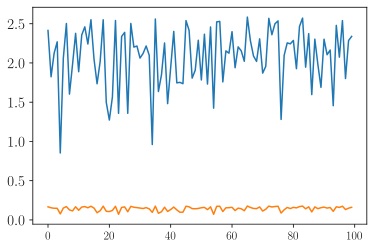

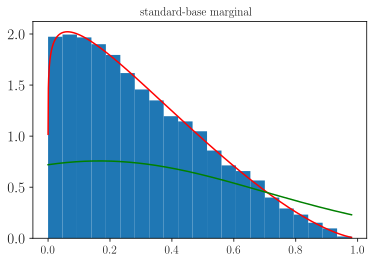

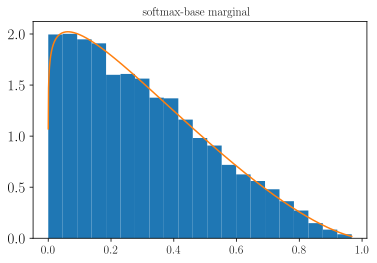

standard:  2.655107700568455 inverse softmax:  0.506567551006287
a:  [2 2 3]


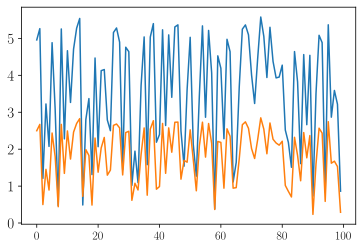

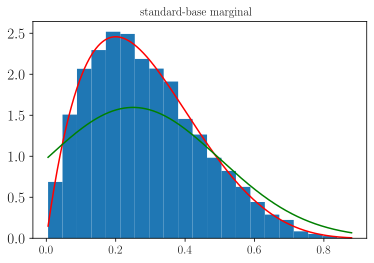

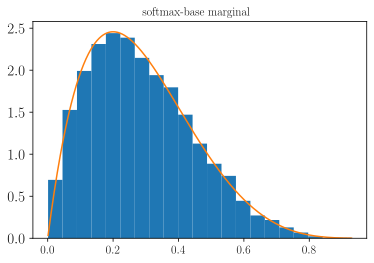

standard:  0.6046146386515818 inverse softmax:  0.2530532758913998
a:  [ 8  9 10]


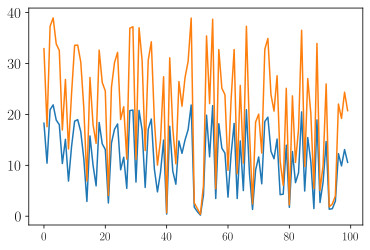

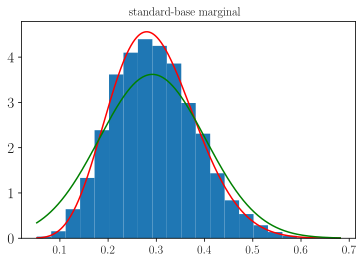

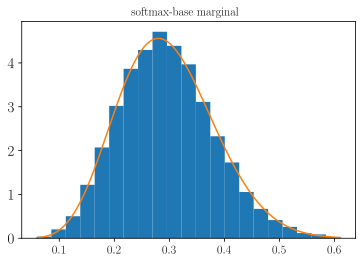

standard:  -0.6281287385301106 inverse softmax:  0.06162902786709675


(2.6315936006899263, 0.8212498547647836)

In [15]:
a_s = np.array([1.1, 1.2, 1.3])
a_m = np.array([2,2,3])
a_l = np.array([8,9,10])

test_As = [a_s, a_m, a_l]
#test_As = [a_m, a_l]
KL_div_samples_combinations3(test_As, num_samples=10000, verbose=True, plot=True)

# KL divergence turns negative and we don't know why. It just doesn't make sense at all.

In [16]:
a = np.array([20,20,20])
mu_test = dirichlet_mu(a)
Sigma_test = dirichlet_Sigma(a) 

x_test = np.array([1/3, 1/3, 1/3])
#x_test = np.array([0.2,0.2,0.6])
print(mv_norm.pdf(x_test, mu_test, Sigma_test))
print(dirichlet.pdf(x_test, a))

141.97908175139875
49.07137376660519


# Plot to understand what's going on 

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib 
import math
from functools import reduce
from math import gamma
from operator import mul
from scipy.special import loggamma
from scipy.stats import dirichlet, multivariate_normal

import torch
import tikzplotlib

In [18]:
from scipy.special import gammaln, xlogy

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)


midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]
def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)


def softmax_transform(a):
    x = np.exp(a)/np.sum(np.exp(a))
    return(x)

def beta_function(alpha):
    return(np.exp(np.sum([loggamma(a_i) for a_i in alpha]) - loggamma(np.sum(alpha))))    

class Dirichlet(object):
    def __init__(self, alpha):
        self._alpha = np.array(alpha)
        self._coef = np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))    
        
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        return(np.exp(- self._coef+ np.sum((xlogy(self._alpha-1, x.T)).T, 0)))
    
class Normal3D(object):
    
    def __init__(self, mu, Sigma):
        self.mu = np.array(mu)
        self.Sigma = np.array(Sigma)
        self.const = 1 / (np.sqrt((2*np.pi)**3 * np.linalg.det(Sigma)))
        
    def pdf(self, x):
        """Calculate 3D Gaussian"""
        y = self.const * np.exp(-0.5 * (x - self.mu).T @ self.Sigma @ (x - self.mu))
        return(y)
    
class logitNormal3D(object):
    
    def __init__(self, mu, Sigma):
        self.mu = np.array(mu)
        self.Sigma = np.array(Sigma)
        self.const = 1/ (np.sqrt(np.linalg.det(2 * np.pi * self.Sigma)))
        
    def pdf(self, x):
        part_one = self.const / np.prod(x)
        logistic = logistic_transform(x)
        part_two = np.exp(-0.5*(logistic - self.mu).T @ self.Sigma @ (logistic - self.mu))
        y = part_one * part_two
        return(y)

def draw_pdf_contours(dist, filename='delete.png', nlevels=200, subdiv=5, **kwargs):

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]
    xys = [xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)]
    #print(len(pvals))
    #print(xys)
    print(len(xys))

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show();
    
#draw_pdf_contours(Dirichlet([5, 5, 5]))

In [19]:
def argmin_norm(sample, positions):
    return(np.argmin(np.sum(np.square(sample - positions), axis=1)))

def sample_dirichlet_contours(alpha, nlevels=200, subdiv=5, num_samples=100000, **kwargs):

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    dirichlet_samples = dirichlet.rvs(alpha, size=num_samples)
    counts = np.zeros(len(xys))
    for x in dirichlet_samples:
        counts[argmin_norm(x, xys)] += 1
    
    pvals = counts/num_samples

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.show();
    
def sample_sm_Normal_contours(mu, sigma, filename='delete.png', nlevels=200, subdiv=5, num_samples=100000, **kwargs):

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    gaussian_samples = multivariate_normal.rvs(mean=mu, cov=sigma, size=num_samples)
    softmax_gaussian_samples = np.array([softmax_transform(x) for x in gaussian_samples])
    counts = np.zeros(len(xys))
    for x in softmax_gaussian_samples:
        counts[argmin_norm(x, xys)] += 1
    
    pvals = counts/num_samples

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show();
    
    
def LA_Normal_contours(mu, Sigma, filename='delete.png', nlevels=200, subdiv=5, **kwargs):

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    pvals = mv_norm.pdf(xys, mu, Sigma)

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show();
    
    

561


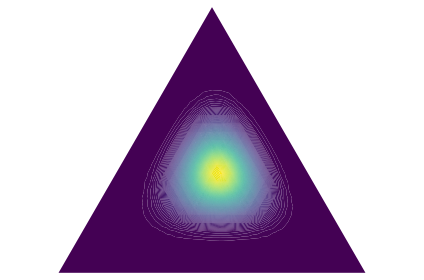

In [20]:
a = np.array([8, 9, 10])
#a = np.array([4,5,6])
#sample_dirichlet_contours(a)
#sample_sm_Normal_contours(np.array([-1, 2, -1]), 0.1*np.eye(3))
draw_pdf_contours(Dirichlet(a), filename='Dirichlet_pdf.png')

mu_test = dirichlet_mu(a)
Sigma_test = dirichlet_Sigma(a) + 1e-8*np.eye(len(a))
#LA_Normal_contours(mu_test, Sigma_test, filename='Fake_softmax_Gaussian.png')

# this looks pretty good. Not sure wtf is going on with the KL divergence

# Compute KL divergence, Attempt 6

In [21]:
from scipy.stats import norm

def KL_div_samples_dirichlet6(a, num_samples, softmax=False, plot=False, eps=1e-8):
    
    dirichlet_samples = dirichlet.rvs(a, size=num_samples)
    num_bins = int(np.cbrt(2145)) #third root of num samples
    
    if softmax:
    
        dir_samples_inv_sm = inverse_softmax_transform_all(dirichlet_samples)
        mu_dir_inv_sm = dirichlet_t_softmax_mu(a)
        Sigma_dir_inv_sm = dirichlet_t_softmax_Sigma(a)
        print(Sigma_dir_inv_sm)
        norm_samples = mv_norm.rvs(mu_dir_inv_sm, Sigma_dir_inv_sm, size=num_samples)

        norm_samples_sm = np.array([softmax_transform(x) for x in norm_samples])
        dir_samples_sm = np.array([softmax_transform(x) for x in dir_samples_inv_sm])
        
        subdiv = 6
        nlevels= 200
        refiner = tri.UniformTriRefiner(triangle)
        trimesh = refiner.refine_triangulation(subdiv=subdiv)
        xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
        counts_gaussian_sm = np.zeros(len(xys))
        for x in norm_samples_sm:
            counts_gaussian_sm[argmin_norm(x, xys)] += 1

        pvals_gaussian_sm = counts_gaussian_sm/num_samples
        
        counts_dir_sm = np.zeros(len(xys))
        for x in dir_samples_sm:
            counts_dir_sm[argmin_norm(x, xys)] += 1

        pvals_dir_sm = counts_dir_sm/num_samples
        print(len(pvals_dir_sm))
        
        if plot:
            plt.tricontourf(trimesh, pvals_gaussian_sm, nlevels)
            plt.axis('equal')
            plt.xlim(0, 1)
            plt.ylim(0, 0.75**0.5)
            plt.axis('off')
            plt.tight_layout()
            plt.title('Normal sm')
            plt.show();

            plt.tricontourf(trimesh, pvals_dir_sm, nlevels)
            plt.axis('equal')
            plt.xlim(0, 1)
            plt.ylim(0, 0.75**0.5)
            plt.axis('off')
            plt.title('Dirichlet sm')
            plt.show();

        KL_div_inv_sm_ = np.mean(pvals_dir_sm * (np.log(pvals_dir_sm+eps) - np.log(pvals_gaussian_sm+eps)))
            
        return(KL_div_inv_sm_)
    
    else:
    
        mu_dir = dirichlet_mu(a)
        print("mu: ", mu_dir)
        Sigma_dir = dirichlet_Sigma(a)
        print("Sigma: ", Sigma_dir)
        
        subdiv = 6
        nlevels= 200
        refiner = tri.UniformTriRefiner(triangle)
        trimesh = refiner.refine_triangulation(subdiv=subdiv)
        xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
        gaussian_samples = multivariate_normal.rvs(mean=mu_dir, cov=Sigma_dir, size=num_samples)
        gaussian_samples = np.array([x / np.abs(x).sum() for x in gaussian_samples])
        counts_gaussian = np.zeros(len(xys))
        for x in gaussian_samples:
            counts_gaussian[argmin_norm(x, xys)] += 1

        pvals_gaussian = counts_gaussian/num_samples
        
        dirichlet_samples = dirichlet.rvs(a, size=num_samples)
        counts_dir = np.zeros(len(xys))
        for x in dirichlet_samples:
            counts_dir[argmin_norm(x, xys)] += 1

        pvals_dir = counts_dir/num_samples
        print(len(pvals_dir))

        if plot:
            plt.tricontourf(trimesh, pvals_gaussian, nlevels)
            plt.axis('equal')
            plt.xlim(0, 1)
            plt.ylim(0, 0.75**0.5)
            plt.axis('off')
            plt.tight_layout()
            plt.title('Normal')
            plt.show();

            plt.tricontourf(trimesh, pvals_dir, nlevels)
            plt.axis('equal')
            plt.xlim(0, 1)
            plt.ylim(0, 0.75**0.5)
            plt.axis('off')
            plt.title('Dirichlet')
            plt.show();

        KL_div_ = np.mean(pvals_dir * (np.log(pvals_dir+eps) - np.log(pvals_gaussian+eps)))
            
        return(KL_div_)
        

In [22]:
def KL_div_samples_combinations6(params, num_samples, plot=False, verbose=True):
    
    As = params
    
    KL_div_sum = 0
    KL_div_sm_sum = 0

    for a in As:

        if verbose:
            print("a: ", a)

        if np.min(a) < 1: #if it contains a value smaller than 1
            print("a_i < 1: not legitimate in standard base")
            KL_div_ = np.nan
        else:
            KL_div_ = KL_div_samples_dirichlet6(a, num_samples=num_samples, plot=plot)

        #compute KL-div for logit base
        KL_div_sm_ = KL_div_samples_dirichlet6(a, num_samples=num_samples, softmax=True, plot=plot)
        KL_div_sm_sum += KL_div_sm_
        KL_div_sum += KL_div_

        if verbose:
            print("standard: ", KL_div_, "inverse softmax: ", KL_div_sm_)

            
    return(KL_div_sum, KL_div_sm_sum)

In [23]:
a_s = np.array([1.1, 1.2, 1.3])
a_m = np.array([2,2,3])
a_l = np.array([20,20,20])#np.array([8,9,10])

test_As = [a_s, a_m, a_l]
#test_As = [a_m, a_l]
KL_div_samples_combinations6(test_As, num_samples=10000, verbose=True, plot=False)

a:  [1.1 1.2 1.3]
mu:  [0.16666667 0.33333333 0.5       ]
Sigma:  [[0.27777778 0.         0.        ]
 [0.         0.55555556 0.        ]
 [0.         0.         0.83333333]]
2145
[[ 0.58210308 -0.3017353  -0.28036778]
 [-0.3017353   0.55685056 -0.25511526]
 [-0.28036778 -0.25511526  0.53548304]]
2145
standard:  0.0012230170860663646 inverse softmax:  0.00035916961846298525
a:  [2 2 3]
mu:  [0.25 0.25 0.5 ]
Sigma:  [[0.0625 0.     0.    ]
 [0.     0.0625 0.    ]
 [0.     0.     0.125 ]]
2145
[[ 0.31481481 -0.18518519 -0.12962963]
 [-0.18518519  0.31481481 -0.12962963]
 [-0.12962963 -0.12962963  0.25925926]]
2145
standard:  0.0005324086356448453 inverse softmax:  0.0002708088788579613
a:  [20 20 20]
mu:  [0.33333333 0.33333333 0.33333333]
Sigma:  [[0.00584795 0.         0.        ]
 [0.         0.00584795 0.        ]
 [0.         0.         0.00584795]]
2145
[[ 0.03333333 -0.01666667 -0.01666667]
 [-0.01666667  0.03333333 -0.01666667]
 [-0.01666667 -0.01666667  0.03333333]]
2145
standar

(0.0018081935279640146, 0.0006837246074472759)

# Calculate KL-divergence for growing a_i and plot it

In [24]:
a_0 = np.array([0.8, 0.8, 0.8])
multiplier = np.array([1.5, 1, 0.75])
As = np.array([np.array(a_0 * multiplier * i) for i in range(1,11)])
print(As)

[[ 1.2  0.8  0.6]
 [ 2.4  1.6  1.2]
 [ 3.6  2.4  1.8]
 [ 4.8  3.2  2.4]
 [ 6.   4.   3. ]
 [ 7.2  4.8  3.6]
 [ 8.4  5.6  4.2]
 [ 9.6  6.4  4.8]
 [10.8  7.2  5.4]
 [12.   8.   6. ]]


In [25]:
KL_results_linear = []

for s in range(1):
    print("seed: ", s)
    np.random.seed(s)
    
    results_seed = []
    for a_ in As:
        print(a_)
        KL_ = KL_div_samples_combinations6([a_], verbose=True, num_samples=100000, plot=False)
        print(KL_)
        results_seed.append(KL_)
    
    KL_results_linear.append(results_seed)

seed:  0
[1.2 0.8 0.6]
a:  [1.2 0.8 0.6]
a_i < 1: not legitimate in standard base
[[ 0.69444444 -0.27777778 -0.41666667]
 [-0.27777778  0.83333333 -0.55555556]
 [-0.41666667 -0.55555556  0.97222222]]
2145
standard:  nan inverse softmax:  0.00012257298998097948
(nan, 0.00012257298998097948)
[2.4 1.6 1.2]
a:  [2.4 1.6 1.2]
mu:  [0.63636364 0.27272727 0.09090909]
Sigma:  [[0.2892562  0.         0.        ]
 [0.         0.12396694 0.        ]
 [0.         0.         0.04132231]]
2145
[[ 0.34722222 -0.13888889 -0.20833333]
 [-0.13888889  0.41666667 -0.27777778]
 [-0.20833333 -0.27777778  0.48611111]]
2145
standard:  0.0004178068580113841 inverse softmax:  9.105773039712934e-05
(0.0004178068580113841, 9.105773039712934e-05)
[3.6 2.4 1.8]
a:  [3.6 2.4 1.8]
mu:  [0.54166667 0.29166667 0.16666667]
Sigma:  [[0.11284722 0.         0.        ]
 [0.         0.06076389 0.        ]
 [0.         0.         0.03472222]]
2145
[[ 0.23148148 -0.09259259 -0.13888889]
 [-0.09259259  0.27777778 -0.18518519]


In [26]:
# handle the data
KL_results_linear = np.array(KL_results_linear)

# take the mean over the 10 seeds
KL_results_linear_mean = KL_results_linear.mean(0)
print(np.shape(KL_results_linear_mean))

(10, 2)


In [27]:
KL_results_linear_mean

array([[           nan, 1.22572990e-04],
       [4.17806858e-04, 9.10577304e-05],
       [2.23563445e-04, 5.46679861e-05],
       [1.52592589e-04, 4.72185511e-05],
       [1.12267018e-04, 3.69858275e-05],
       [8.84775184e-05, 3.18937276e-05],
       [7.28336255e-05, 2.67238880e-05],
       [6.11583881e-05, 2.39043094e-05],
       [5.26000171e-05, 1.85503548e-05],
       [4.58924191e-05, 1.71871040e-05]])

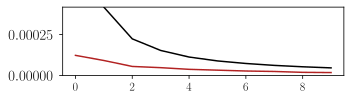

In [28]:
# make plots

fig = plt.figure(figsize=(5, 1.5))
plt.plot(KL_results_linear_mean[:,0], label='standard', color='black')
plt.plot(KL_results_linear_mean[:,1], label='softmax', color='firebrick')
plt.ylim(0, np.nanmax(KL_results_linear_mean))
plt.tight_layout()

#"""
tpl.save(
    "KL_Dirichlet.tex",
    figure = fig,
    axis_width = "\\figwidth",
    axis_height= "\\figheight",
    tex_relative_path_to_data=".",
    override_externals=False,
    float_format=".3g"
)
#"""

plt.savefig('KL_Dirichlet.pdf')

plt.show();

# calculate MMD for growing a_i and plot it

In [29]:
MMD_results_linear = []

for s in range(10):
    print("seed: ", s)
    np.random.seed(s)
    
    results_seed = []
    for a_ in As:
        print(a_)
        MMD_ = MMD_combinations(params = [a_], n_samples=2000)
        print(MMD_)
        results_seed.append(MMD_)
    
    MMD_results_linear.append(results_seed)

seed:  0
[1.2 0.8 0.6]
a:  [1.2 0.8 0.6]
a_i < 1 doesn't yield a Laplace Approximation in standard basis
standard:  nan softmax:  0.015007823705673218
(tensor([nan]), tensor([0.0150]))
[2.4 1.6 1.2]
a:  [2.4 1.6 1.2]
standard:  0.05764055252075195 softmax:  0.008714497089385986
(tensor([0.0576]), tensor([0.0087]))
[3.6 2.4 1.8]
a:  [3.6 2.4 1.8]
standard:  0.013963162899017334 softmax:  0.004088044166564941
(tensor([0.0140]), tensor([0.0041]))
[4.8 3.2 2.4]
a:  [4.8 3.2 2.4]
standard:  0.006273031234741211 softmax:  0.0019507408142089844
(tensor([0.0063]), tensor([0.0020]))
[6. 4. 3.]
a:  [6. 4. 3.]
standard:  0.0025414228439331055 softmax:  0.002438068389892578
(tensor([0.0025]), tensor([0.0024]))
[7.2 4.8 3.6]
a:  [7.2 4.8 3.6]
standard:  0.0023962855339050293 softmax:  0.00249403715133667
(tensor([0.0024]), tensor([0.0025]))
[8.4 5.6 4.2]
a:  [8.4 5.6 4.2]
standard:  0.0020980238914489746 softmax:  0.0
(tensor([0.0021]), tensor([0.]))
[9.6 6.4 4.8]
a:  [9.6 6.4 4.8]
standard:  0.001

standard:  0.06509894132614136 softmax:  0.0072443485260009766
(tensor([0.0651]), tensor([0.0072]))
[3.6 2.4 1.8]
a:  [3.6 2.4 1.8]
standard:  0.014900267124176025 softmax:  0.003961384296417236
(tensor([0.0149]), tensor([0.0040]))
[4.8 3.2 2.4]
a:  [4.8 3.2 2.4]
standard:  0.005769789218902588 softmax:  0.003115534782409668
(tensor([0.0058]), tensor([0.0031]))
[6. 4. 3.]
a:  [6. 4. 3.]
standard:  0.0034331083297729492 softmax:  0.0008993148803710938
(tensor([0.0034]), tensor([0.0009]))
[7.2 4.8 3.6]
a:  [7.2 4.8 3.6]
standard:  0.002176344394683838 softmax:  0.0009347200393676758
(tensor([0.0022]), tensor([0.0009]))
[8.4 5.6 4.2]
a:  [8.4 5.6 4.2]
standard:  0.0015658140182495117 softmax:  0.0007079243659973145
(tensor([0.0016]), tensor([0.0007]))
[9.6 6.4 4.8]
a:  [9.6 6.4 4.8]
standard:  0.0008753538131713867 softmax:  0.001899123191833496
(tensor([0.0009]), tensor([0.0019]))
[10.8  7.2  5.4]
a:  [10.8  7.2  5.4]
standard:  0.0006818175315856934 softmax:  0.0009313225746154785
(tens

In [30]:
# handle the data
MMD_results_linear = np.array(MMD_results_linear)

# take the mean over the 10 seeds
MMD_results_linear_mean = MMD_results_linear.mean(0)
print(np.shape(MMD_results_linear_mean))

(10, 2)


In [31]:
MMD_results_linear_mean

array([[       nan, 0.0150071 ],
       [0.06199542, 0.00744106],
       [0.01443574, 0.00387787],
       [0.00605678, 0.00293465],
       [0.00358706, 0.00177207],
       [0.00211405, 0.00145393],
       [0.00152791, 0.00057152],
       [0.00113844, 0.0007648 ],
       [0.00078481, 0.00063583],
       [0.00072763, 0.00064546]], dtype=float32)

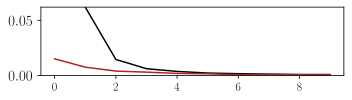

In [32]:
# make plots

fig = plt.figure(figsize=(5, 1.5))
plt.plot(MMD_results_linear_mean[:,0], label='standard', color='black')
plt.plot(MMD_results_linear_mean[:,1], label='softmax', color='firebrick')
plt.ylim(0, np.nanmax(MMD_results_linear_mean))
plt.tight_layout()

#"""
tpl.save(
    "MMD_Dirichlet.tex",
    figure = fig,
    axis_width = "\\figwidth",
    axis_height= "\\figheight",
    tex_relative_path_to_data=".",
    override_externals=False,
    float_format=".3g"
)
#"""
plt.savefig('MMD_Dirichlet.pdf')

plt.show();